# Analysis of Field Metaproteomics Data

This script is used to generate plots of metaproteomics data obtained from field samples and analyzed with DIA Mass Spectrometry on an Orbitrap Astral Mass Spectrometer. 

## Pre-Requisites
Please run your samples through the script 'merge_metaproteomics.ipynb' first. You should get an output file that contains all taxonomic (eggNOG) and biochemical (KEGG, KO, GO) data necessary.

## Step 1: Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
import matplotlib as mpl
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "notebook"
import kaleido

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import cmocean

mpl.rcParams["font.family"] = "Arial"

## Step 2: Import Data, Normalize, Merge files
The output file from the previous step (merge_metaproteomics.ipynb) should have the name merged_prot_tax_ann_{sample_name}.csv. Please run this script first before importing data. 

Replace the filepath with the path to your metaproteomics datafile. 
If you have the amount of liters filtered through each filter associated with each sample, then please upload the metadata file with 

### Step 2.1 Import

In [2]:
# Main DIA metaproteomics table
df = pd.read_csv("../data/metaP/final_output/merged_prot_tax_ann_AE2504.csv", sep=",")
print(df)

# Dataframe metadata contains metadata information on how many liters were filtered, lat, long, salinity, temperature, and fluorescence data. 
metadata = pd.read_csv("../data/metaP/final_output/station_liters.csv", sep=",")

# Function to convert "DD MM.MMM" to decimal degrees
def dm_to_dd(coord):
    deg, minutes = coord.split()
    return float(deg) + float(minutes)/60

metadata["lat"] = metadata["lat"].apply(dm_to_dd)
metadata["long"] = metadata["long"].apply(dm_to_dd)
metadata["long"] = -metadata["long"].abs()
metadata = metadata.rename(columns={"fluorescence (µg/l)": "fluorescence"})

print(metadata)

                                         transcript_name  \
0                           megahit_HN001_k141_100230.p1   
1                           megahit_HN001_k141_100427.p1   
2                           megahit_HN001_k141_100444.p1   
3                           megahit_HN001_k141_100576.p1   
4                           megahit_HN001_k141_100648.p1   
...                                                  ...   
45234  velvet_HN044_NODE_46161_length_634_cov_6.65930...   
45235  velvet_HN044_NODE_546770_length_555_cov_4.5261...   
45236  velvet_HN044_NODE_551706_length_275_cov_6.5490...   
45237  velvet_HN044_NODE_632126_length_747_cov_3.6974...   
45238  velvet_HN044_NODE_680272_length_245_cov_3.2448...   

                       seed_ortholog         evalue  score  \
0              110662.Syncc9605_1952   4.200000e-87  327.4   
1                522306.CAP2UW1_0503   1.100000e-64  252.7   
2                  335992.SAR11_0368   4.500000e-92  344.0   
3                     84588.SYN

### Step 2.2 Sample Info + Merge with Metadata

In [3]:
# sample columns are columns containing "UW"
sample_cols = [c for c in df.columns if "UW" in c]

def parse_sample(col):
    """
    This function extracts the station number and filter size from the sample names. 
    Example: '24_UW73_51' → station='UW73', filter='51'
    """
    parts = col.split("_")
    station = parts[1]
    filter_size = parts[2]
    return station, filter_size

# The dataframe sample info contains all sample names, sations, and filter sizes stored in a dataframe. It uses the function parse_sample(). 
sample_info = pd.DataFrame(
    [parse_sample(c) for c in sample_cols],
    columns=["station", "filter"],
    index=sample_cols
)
print(sample_info)

metadata = metadata.merge(
    sample_info,
    left_on="station",
    right_index=True,
    how="left"
)
    
print(metadata)

            station filter
25_UW73_51     UW73     51
41_UW89_02     UW89     02
35_UW77_02     UW77     02
49_UW96_02     UW96     02
33_UW77_51     UW77     51
19_UW70_02     UW70     02
61_UW103_02   UW103     02
13_UW28_02     UW28     02
55_UW99_02     UW99     02
38_UW85_51     UW85     51
40_UW89_51     UW89     51
60_UW103_51   UW103     51
54_UW99_51     UW99     51
48_UW96_51     UW96     51
        station    station_x  liters        lat       long  salinity  \
0    13_UW28_02   13_UW28_02    87.4  31.752200 -64.006667    36.842   
1    19_UW70_02   19_UW70_02    51.7  32.441417 -63.827800    36.786   
2    25_UW73_51   25_UW73_51    52.2  33.002983 -64.622983    36.658   
3    33_UW77_51   33_UW77_51    53.9  33.484750 -65.674167    36.710   
4    35_UW77_02   35_UW77_02    53.9  33.484750 -65.674167    36.710   
5    38_UW85_51   38_UW85_51    47.5  34.410967 -67.908850    36.723   
6    40_UW89_51   40_UW89_51    35.5  35.191650 -68.834683    36.715   
7    41_UW89_02   4

### 2.3 Normalize Protein Normalized peak area / Liter seawater filtered

In [4]:
sample_cols = [col for col in df.columns if col in metadata["station"].values]
print(sample_cols)

# Create a mapping of station -> liters
liters_map = metadata.set_index("station")["liters"].to_dict()

# Divide each sample column by its corresponding liters
df_norm = df.copy()
for col in sample_cols:
    df_norm[col] = df_norm[col] / liters_map[col]

print(df_norm.head())

['25_UW73_51', '41_UW89_02', '35_UW77_02', '49_UW96_02', '33_UW77_51', '19_UW70_02', '61_UW103_02', '13_UW28_02', '55_UW99_02', '38_UW85_51', '40_UW89_51', '60_UW103_51', '54_UW99_51', '48_UW96_51']
                transcript_name                  seed_ortholog         evalue  \
0  megahit_HN001_k141_100230.p1          110662.Syncc9605_1952   4.200000e-87   
1  megahit_HN001_k141_100427.p1            522306.CAP2UW1_0503   1.100000e-64   
2  megahit_HN001_k141_100444.p1              335992.SAR11_0368   4.500000e-92   
3  megahit_HN001_k141_100576.p1                 84588.SYNW2070  3.800000e-159   
4  megahit_HN001_k141_100648.p1  1122137.AQXF01000003_gene2089   1.600000e-45   

   score                                          eggNOG_OG  \
0  327.4  COG1239@1|root,COG1239@2|Bacteria,1G13M@1117|C...   
1  252.7  COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...   
2  344.0  COG0443@1|root,COG0443@2|Bacteria,1MVEN@1224|P...   
3  567.4  COG0090@1|root,COG0090@2|Bacteria,1G1P7@1117|C...   

## Step 3: Plot stations against map, chla and temperature

In [6]:
fig = px.scatter_map(
    metadata,
    lat="lat",
    lon="long",
    color="temperature",       # seawater temperature color
    size="fluorescence",       # dot size
    hover_name="station_y",
    hover_data={
        "temperature": True,
        "salinity": True,
        "fluorescence": True
    },
    size_max=30,
    color_continuous_scale="thermal",  # good for temperature
    opacity=0.85,
    zoom=4
)

fig.update_layout(
    mapbox=dict(
        style="stamen-terrain",
        center=dict(
            lat=metadata["lat"].mean(),
            lon=metadata["long"].mean()
        )),
    paper_bgcolor="white",
    plot_bgcolor="white",
    margin=dict(pad=0, r=2, t=2, b=2, l=2),
    font=dict(
        family="Arial",
        size=18,
        color="black"
    )
)

fig.update_layout(coloraxis_colorbar_title_text="Temperature (°C)")
#fig.write_image('../figures/Fig1_stationmap.pdf')
#fig.write_html("../figures/Fig1_stationmap.html", include_plotlyjs="cdn")
fig.show()

### 2.2 Normalize protein data by liters filtered. 
To be able to compare the amounts of protein across sample stations, we need to normalize the protein data by the amount of water filtered during the cruise. 

In [6]:
'''
Following function will match the 'metadata' rows with the 'df' sample columns and divide by the liters of seawater filtered.
'''

def norm_liters(df, metadata):
    # Create mapping from station name → liters
    liters_map = sample_info['station'].set_index("station")["liters"]



## Step 4: Data Overview - NMDS

In [16]:
X = df_norm[sample_cols].T

# Bray–Curtis distance
dist = squareform(pdist(X, metric="braycurtis"))

nmds = MDS(n_components=2, metric=False, dissimilarity="precomputed",
           random_state=42, max_iter=3000)
coords = nmds.fit_transform(dist)

nmds_df = pd.DataFrame(coords, columns=["NMDS1", "NMDS2"])
nmds_df["sample"] = sample_cols
nmds_df = nmds_df.join(sample_info, on="sample")

palette = sns.color_palette('viridis')
print("Stress:", nmds.stress_)

Stress: 0.05112216130455221


/Users/fadimestemmer/miniconda3/envs/AE2504_metaP/lib/python3.13/site-packages/sklearn/manifold/_mds.py:744: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.

/Users/fadimestemmer/miniconda3/envs/AE2504_metaP/lib/python3.13/site-packages/sklearn/manifold/_mds.py:754: FutureWarning:

The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.

/Users/fadimestemmer/miniconda3/envs/AE2504_metaP/lib/python3.13/site-packages/sklearn/manifold/_mds.py:771: FutureWarning:

The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.

/Users/fadimestemmer/miniconda3/envs/AE2504_metaP/lib/python3.13/site-packages/sklearn/manifold/_mds.py:779: FutureWarning:

Use metric_mds=False instead of metric=False. The support for metric={True/False} will be dropped in 1.10.



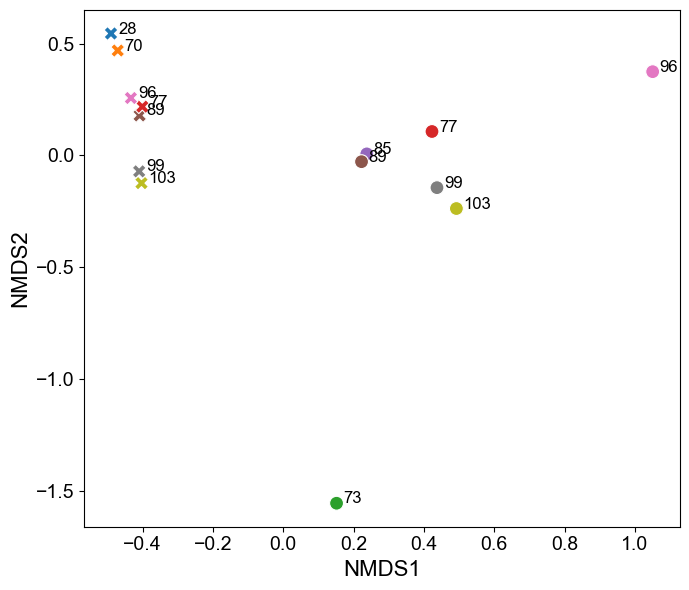

In [8]:
# Extract numeric station ID
nmds_df["UW_num"] = (
    nmds_df["station"]
    .str.replace("UW", "", regex=False)
    .astype(int)
)

station_order = (
    nmds_df
    .sort_values("UW_num")["station"]
    .unique()
)


nmds_df["station"] = pd.Categorical(
    nmds_df["station"],
    categories=station_order,
    ordered=True
)

plt.figure(figsize=(7,6))

ax = sns.scatterplot(
    data=nmds_df,
    x="NMDS1",
    y="NMDS2",
    hue="station", 
    style = "filter", 
    s=100,
    legend=False
)

dx, dy = 0.02, 0.02  # tweak as needed

for _, row in nmds_df.iterrows():
    ax.text(
        row["NMDS1"] + dx,
        row["NMDS2"] + dy,
        row["UW_num"], 
        fontsize=12,
        ha="left",
        va="center"
    )

ax.tick_params(axis="both", labelsize=14)
ax.set_xlabel("NMDS1", fontsize=16)
ax.set_ylabel("NMDS2", fontsize=16)
plt.tight_layout()
plt.savefig('../figures/Fig2_NMDS.pdf', format='pdf')
plt.show()

## Step 5: Analyze Microbial Community Composition 

In [7]:
# Extract numeric UW value for sorting
sample_info["UW_num"] = (
    sample_info["station"]
    .str.replace("UW", "", regex=False)
    .astype(int)
)

sample_info = sample_info.sort_values("UW_num")

sorted_samples = sample_info.index.tolist()

def select_tax(df_norm, tax_level='domain' ):
    tax_level = tax_level   # change to domain/supergroup/division/class/order/family/genus/species
    
    tax_df = ( # aggregate normalized counts by taxonomic level 
        df_norm
        .groupby(tax_level)[sorted_samples]
        .sum()
        .T
    )
    print(tax_df)
    
    tax_order = ( #determines order of taxa by abundance
        df_norm
        .groupby(tax_level)[sample_cols]
        .sum()
        .sum(axis=1) # sum total count per taxon
        .sort_values(ascending=False) # sort the taxa by descending abundance for the order to display in the bar plot. 
        .index
    )
    
    
    # Convert to relative abundance
    tax_df_rel = tax_df.div(tax_df.sum(axis=1), axis=0) #divide each row by its sum
    tax_df_rel = tax_df_rel[tax_order] #reorder columns by tax_order = most abundant taxa first. 
    return tax_df_rel

In [8]:
def plot_community(df_norm, tax_level='domain', filtersize=None, sample_info=sample_info, save_path=None):
    """
    Plot microbial community composition as stacked bar chart.

    Parameters:
    - df_norm: DataFrame of normalized counts with a taxonomic level column
    - tax_level: Taxonomic level to aggregate (domain/supergroup/division/class/order/family/genus/species)
    - filtersize: Optional filter size (e.g., '02') to select subset of samples
    """
    
    # Filter by filter size if requested
    if filtersize is not None:
        sample_info = sample_info[sample_info['filter']==filtersize]
    filtered_samples = sample_info.index.tolist()
    # Create mapping: full sample name → UW station name
    station_labels = sample_info.loc[filtered_samples, "station"]

    # --- Aggregate and convert to relative abundance ---
    tax_df = df_norm.groupby(tax_level)[filtered_samples].sum().T
    tax_order = tax_df.sum().sort_values(ascending=False).index
    tax_df_rel = tax_df.div(tax_df.sum(axis=1), axis=0)[tax_order]

    # --- Plot ---
    fig = px.bar(
        tax_df_rel,
        x=station_labels,
        y=tax_df_rel.columns,
        color_discrete_sequence=px.colors.qualitative.Safe,
        barmode='stack',
        template="plotly_white",
        width=1500,
        height=800,
        labels={"index":"Station","value":"Fractional Sum","variable":"Taxon"}
    )

    fig.update_traces(marker_line_width=0)
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, range=[0,1])
    fig.update_layout(font_family="Arial", font_size=18, autosize=True)

    # --- Save files ---
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)

        filename_base = f"community_{tax_level}"
        if filtersize:
            filename_base += f"_filter{filtersize}"

        html_file = os.path.join(save_path, filename_base + ".html")
        pdf_file = os.path.join(save_path, filename_base + ".pdf")

        # Interactive HTML
        fig.write_html(html_file, include_plotlyjs="cdn")

        # Static PDF
        fig.write_image(pdf_file)

    return fig

In [24]:
plot_community(df_norm, tax_level='order', filtersize='02', save_path='../figures/OSM2026/Community/')  # change to domain/supergroup/division/class/order/family/genus/species

In [25]:
plot_community(df_norm, tax_level='order', filtersize='51', save_path='../figures/OSM2026/Community/')  # change to domain/supergroup/division/class/order/family/genus/species

In [13]:
plot_community(df_norm, tax_level='supergroup', filtersize=None, save_path='../figures/OSM2026/')

## Step 6: Protein groups

In [9]:
print(sample_info)
samples_02 = sample_info[sample_info["filter"] == "02"].sort_values("UW_num").index.tolist()
samples_51 = sample_info[sample_info["filter"] == "51"].sort_values("UW_num").index.tolist()

            station filter  UW_num
13_UW28_02     UW28     02      28
19_UW70_02     UW70     02      70
25_UW73_51     UW73     51      73
35_UW77_02     UW77     02      77
33_UW77_51     UW77     51      77
38_UW85_51     UW85     51      85
41_UW89_02     UW89     02      89
40_UW89_51     UW89     51      89
49_UW96_02     UW96     02      96
48_UW96_51     UW96     51      96
55_UW99_02     UW99     02      99
54_UW99_51     UW99     51      99
61_UW103_02   UW103     02     103
60_UW103_51   UW103     51     103


In [10]:
def protein_line(df_norm, sample_info, filtersize=None, KEGG=None, KO=None, EC=None, OG=None, PFAM=None, total=None, save_path=None):

    df = df_norm.copy()
    si = sample_info.copy()

    # Sort sample_info by station number
    si = si.sort_values("UW_num")

    # Filter by filtersize (affects columns!)
    if filtersize is not None:
        si = si[si["filter"] == filtersize]

    # Ordered sample names
    sorted_samples = si.index.tolist()

    # Filter proteins by annotation
    if EC is not None:
        df = df[df["EC"].str.startswith(EC, na=False)]
    if KEGG is not None:
        df = df[df["KEGG"] == KEGG]
    if KO is not None:
        df = df[df["KO"] == KO]
    if OG is not None: 
        df = df[df["best_OG_desc"].str.contains(OG)]
    if PFAM is not None: 
        df = df[df["PFAMs"]== PFAM]

    # Keep only sorted sample columns
    protein_df = df[sorted_samples].T
    
    # Replace full sample names with station names
    protein_df["station"] = si.loc[protein_df.index, "station"].values

    # Add station + UW number metadata
    protein_df["station"] = si.loc[protein_df.index, "station"].values
    protein_df["UW_num"] = si.loc[protein_df.index, "UW_num"].values
    
    if filtersize is None:
        # Aggregate multiple filters per station
        protein_df = (
            protein_df
            .groupby(["station", "UW_num"])
            .sum()
            .reset_index()
            .sort_values("UW_num")
            .set_index("station")
        )
    else:
        # One filter per station → just relabel and sort
        protein_df = (
            protein_df
            .sort_values("UW_num")
            .set_index("station")
        )

    # Remove helper column
    protein_df = protein_df.drop(columns="UW_num", errors="ignore")

    # Collapse duplicate protein names
    protein_df.columns = df["Preferred_name"].values

    # Calculate total per station (across all selected proteins)
    if total == "yes":
        total_values = protein_df.sum(axis=1)
    
    if EC is not None:
        # Sum duplicate protein names
        protein_df = protein_df.groupby(level=0, axis=1).sum()
    else:
        # Make column names unique to avoid Plotly DuplicateError
        counts = {}
        new_cols = []
        for col in protein_df.columns:
            if col in counts:
                counts[col] += 1
                new_cols.append(f"{col}_{counts[col]}")
            else:
                counts[col] = 0
                new_cols.append(col)
        protein_df.columns = new_cols
    
    # Plot
    fig = go.Figure()
    colors = px.colors.qualitative.Safe

    for i, protein in enumerate(protein_df.columns):
        fig.add_trace(
            go.Scatter(
                x=protein_df.index,
                y=protein_df[protein],
                mode='lines+markers',
                name=protein,
                line=dict(color=colors[i % len(colors)])
            )
        )

    fig.update_layout(
        template="plotly_white",
        width=1200,
        height=700,
        xaxis_title="Station",
        yaxis_title="Amount of protein [µg L<sup>-1</sup>]",
        legend_title="Protein Name",
        font_family="Arial", font_size=18, autosize=True
    )
    if total == "yes":
        fig.add_trace(
            go.Scatter(
                x=protein_df.index,
                y=total_values,
                mode='lines+markers',
                name="Total",
                line=dict(color="black", width=4),
            )
        )

    # Save files
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
    
        filename_base = 'lineplot'
        if filtersize:                
            filename_base += f"_{filtersize}"
    
        html_file = os.path.join(save_path, filename_base + ".html")
        pdf_file = os.path.join(save_path, filename_base + ".pdf")
    
        # Interactive HTML
        fig.write_html(html_file, include_plotlyjs="cdn")
    
        # Static PDF
        fig.write_image(pdf_file)

    return fig

In [11]:
protein_line(df_norm, sample_info, filtersize=None, EC='3.4', total='yes', save_path='../figures/OSM2026/lineplot_VolumeNorm/')

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_55947/4252022695.py:68: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [33]:
protein_line(df_norm, sample_info, filtersize='02', EC='3.4', save_path='../figures/OSM2026/lineplot_VolumeNorm/')

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_20588/4168333434.py:64: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [34]:
protein_line(df_norm, sample_info, filtersize='51', EC='3.4', save_path='../figures/OSM2026/lineplot_VolumeNorm/')

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_20588/4168333434.py:64: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [38]:
protein_line(df_norm, sample_info, filtersize='02', OG='secretion', save_path='../figures/OSM2026/lineplot_VolumeNorm/')

In [20]:
def protein_tax_line(df_norm, sample_info,
                     protein_name,
                     tax_level="Genus",
                     filtersize=None, save_path=None):

    df = df_norm.copy()
    si = sample_info.copy()

    #Sort Stations
    si = si.sort_values("UW_num")

    if filtersize is not None:
        si = si[si["filter"] == filtersize]

    sorted_samples = si.index.tolist()

    # Filter one protein
    mask_pfam = df["PFAMs"].str.contains(protein_name, na=False)
    mask_og = df["best_OG_desc"].str.contains(protein_name, na=False)
    mask_ec = df["EC"].str.startswith(protein_name, na=False)
    mask_name = df["Preferred_name"] == protein_name
    
    if mask_pfam.any():
        df = df[mask_pfam]
    
    if mask_ec.any():
        df = df[mask_ec]
    
    elif mask_og.any():
        df = df[mask_og]
    
    elif mask_name.any():
        df = df[mask_name]
    
    else:
        print("No data found for this protein.")
        return

    # Group one protein
    if tax_level not in df.columns:
        raise ValueError(f"{tax_level} not found in dataframe columns")

    # --- TOTAL protein per sample (across all taxa & all matching rows) ---
    total_per_sample = df[sorted_samples].sum(axis=0)
    
    print("\nTotal protein per sample:")
    for sample in sorted_samples:
        print(sample, total_per_sample[sample])

    unique_taxa = df[tax_level].unique()
    palette = px.colors.qualitative.Safe

    color_map = {
        tax: palette[i % len(palette)]
        for i, tax in enumerate(unique_taxa)
    }

    # Create mapping dataframe for plotting
    sample_meta = si.loc[sorted_samples].copy()
    
    if filtersize is None:
        # Aggregate per station (multiple filters per station)
        
        # Add station + UW number to total
        total_df = pd.DataFrame({
            "value": total_per_sample.values,
            "station": sample_meta["station"].values,
            "UW_num": sample_meta["UW_num"].values
        })
    
        total_df = (
            total_df
            .groupby(["station", "UW_num"])
            .sum()
            .reset_index()
            .sort_values("UW_num")
        )
    
        x_values = total_df["station"].values
        total_values = total_df["value"].values
    
    else:
        # Single filter → just relabel & sort
        sample_meta = sample_meta.sort_values("UW_num")
    
        x_values = sample_meta["station"].values
        total_values = total_per_sample.loc[sample_meta.index].values
    
    # Plot each row separately
    fig = go.Figure()

    for idx, row in df.iterrows():
        # each taxon = a row in all the samples. Checks the taxon in row[taxlevel column specified in fuction argument]
        taxon = row[tax_level] 
        # y_values are all rows summed for each sample. Here the rows already only contain the specified proteins.
        y_values = row[sorted_samples].values

        fig.add_trace(
            go.Scatter(
                x=x_values,
                y=y_values,
                mode='lines+markers',
                name=f"{row['Preferred_name']} | {taxon}",
                line=dict(color=color_map[taxon]),
                legendgroup=taxon,
                showlegend=True
            )
        )

        fig.update_layout(
            template="plotly_white",
            width=1200,
            height=700,
            xaxis_title="Station",
            yaxis_title="Amount of protein in µg L <sup>-1</sup>",
            legend_title= f"Protein Name | {tax_level}",
            title=f"{protein_name}",
            font_family="Arial",
            font_size=18
        )
    
    fig.add_trace(
        go.Scatter(
            x=x_values,
            y=total_per_sample.values,
            mode='lines+markers',
            name="Total",
            line=dict(color="black", width=4),
        )
    )

        # Save files
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
    
        filename_base = f'lineplot_{protein_name}'
        if filtersize:                
            filename_base += f"_{filtersize}"
    
        html_file = os.path.join(save_path, filename_base + ".html")
        pdf_file = os.path.join(save_path, filename_base + ".pdf")
    
        # Interactive HTML
        fig.write_html(html_file, include_plotlyjs="cdn")
    
        # Static PDF
        fig.write_image(pdf_file)

    return fig

In [26]:
protein_tax_line(df_norm, sample_info,
                 protein_name="urtA",
                 tax_level="domain",
                 filtersize="02")


Total protein per sample:
13_UW28_02 1977284.965675057
19_UW70_02 3775033.442940038
35_UW77_02 1166645.1317254175
41_UW89_02 1863072.738028169
49_UW96_02 1760874.3
55_UW99_02 652539.68
61_UW103_02 1223316.1510791369


In [47]:
protein_tax_line(df_norm, sample_info,
                 protein_name="fecA",
                 tax_level="domain",
                 filtersize="02")


Total protein per sample:
13_UW28_02 0.0
19_UW70_02 7141.644100580271
35_UW77_02 5071.224489795918
41_UW89_02 9292.112676056338
49_UW96_02 14724.517857142857
55_UW99_02 0.0
61_UW103_02 9879.604316546762


## Total intensity normalization
STEP 1: Divide each protein normalized peak area by sum of normalized peak area per sample. This will give us value from 0-1.


STEP 2: Normalized peak area by total intensity normalization mapping to total amount of protein extracted. 1 = amount of µg protein extracted per sample

STEP 3: Multiply fractional value (STEP 1) by the total amount of protein to get amount of protein in µg

STEP 4: Divide by L seawater filtered through the filter for the amount of protein in µg per L (concentration) 

In [12]:
# If samples look uniform then use maxLFQ if not use normal intensity. 
total_protein = pd.read_csv('../data/metaP/final_output/total_protein.csv').sort_values("Dataset")
print(total_protein)

# STEP 1 - Total intensity Normalization
df_norm_TI = df.copy()
for col in sample_cols:
    df_norm_TI[col] = df[col] / df[col].sum(axis=0)

print(df_norm_TI.head())

# STEP 2+3+4 - protein amount + Liter seawater filtered
df_final = df_norm_TI.copy()

for col in sample_cols:
    total_ug = total_protein.loc[total_protein['Dataset'] == col, 'total_protein_ug'].values[0]
    print(total_ug)

    volume_L = total_protein.loc[total_protein["Dataset"] == col, "volume_filtered_filtersize"].values[0]
    print(volume_L)

    concentration = total_ug / volume_L
    print(concentration)

    df_final[col] = (df_final[col]* concentration)

### DOUBLE CHECK : Sum of columns * volume_L should give us the total_protein_ug
for col in sample_cols:

    total_ug = total_protein.loc[
        total_protein['Dataset'] == col,
        'total_protein_ug'
    ].values[0]

    volume_L = total_protein.loc[
        total_protein['Dataset'] == col,
        'volume_filtered_filtersize'
    ].values[0]

    reconstructed_total = df_final[col].sum() * volume_L

    print(col)
    print("Original total ug:", total_ug)
    print("Reconstructed total ug:", reconstructed_total)
    print("Difference:", total_ug - reconstructed_total)
    print("-----")

print(df_final.head())

        Dataset  protein_conc_ugul  total_protein_ug  volume_filtered  \
0    13_UW28_02           0.085513             7.696             42.1   
1    19_UW70_02           0.108895             9.801             22.7   
2    25_UW73_51           0.128380            11.554             52.2   
3    33_UW77_51           0.036243             3.262             53.9   
4    35_UW77_02           0.100989             9.089             53.9   
5    38_UW85_51           0.108346             9.751             47.5   
6    40_UW89_51           0.017114             1.540             35.5   
7    41_UW89_02           0.099517             8.957             35.5   
8    48_UW96_51           0.036243             3.262             56.0   
9    49_UW96_02           0.123062            11.076             56.0   
10   54_UW99_51           0.120119            10.811             32.5   
11   55_UW99_02           0.159849            14.386             32.5   
12  60_UW103_51           0.070087             6.30

### NMDS

In [32]:
X = df_final[sample_cols].T

# Bray–Curtis distance
dist = squareform(pdist(X, metric="braycurtis"))

nmds = MDS(n_components=2, metric=False, dissimilarity="precomputed",
           random_state=42, max_iter=3000)
coords = nmds.fit_transform(dist)

nmds_df = pd.DataFrame(coords, columns=["NMDS1", "NMDS2"])
nmds_df["sample"] = sample_cols
nmds_df = nmds_df.join(sample_info, on="sample")

palette = sns.color_palette('viridis')
print("Stress:", nmds.stress_)

Stress: 0.049649617240761404


/Users/fadimestemmer/miniconda3/envs/AE2504_metaP/lib/python3.13/site-packages/sklearn/manifold/_mds.py:744: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.

/Users/fadimestemmer/miniconda3/envs/AE2504_metaP/lib/python3.13/site-packages/sklearn/manifold/_mds.py:754: FutureWarning:

The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.

/Users/fadimestemmer/miniconda3/envs/AE2504_metaP/lib/python3.13/site-packages/sklearn/manifold/_mds.py:771: FutureWarning:

The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.

/Users/fadimestemmer/miniconda3/envs/AE2504_metaP/lib/python3.13/site-packages/sklearn/manifold/_mds.py:779: FutureWarning:

Use metric_mds=False instead of metric=False. The support for metric={True/False} will be dropped in 1.10.



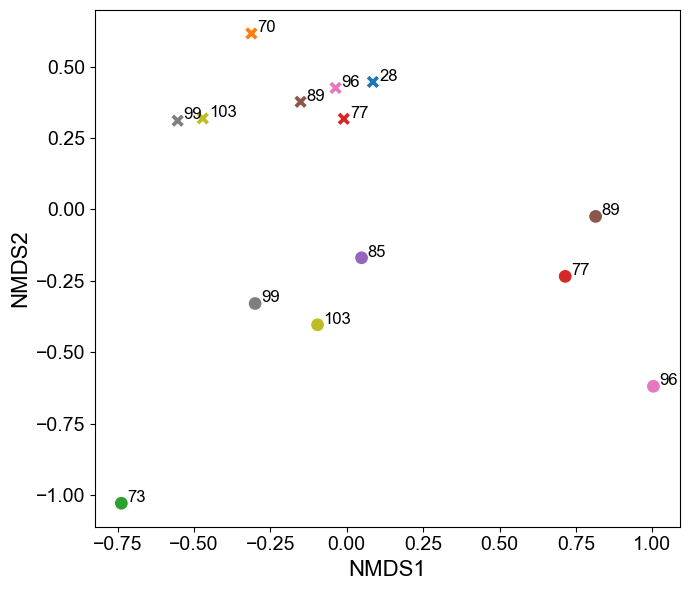

In [7]:
# Extract numeric station ID
nmds_df["UW_num"] = (
    nmds_df["station"]
    .str.replace("UW", "", regex=False)
    .astype(int)
)

station_order = (
    nmds_df
    .sort_values("UW_num")["station"]
    .unique()
)


nmds_df["station"] = pd.Categorical(
    nmds_df["station"],
    categories=station_order,
    ordered=True
)

plt.figure(figsize=(7,6))

ax = sns.scatterplot(
    data=nmds_df,
    x="NMDS1",
    y="NMDS2",
    hue="station", 
    style = "filter", 
    s=100,
    legend=False
)

dx, dy = 0.02, 0.02  # tweak as needed

for _, row in nmds_df.iterrows():
    ax.text(
        row["NMDS1"] + dx,
        row["NMDS2"] + dy,
        row["UW_num"], 
        fontsize=12,
        ha="left",
        va="center"
    )

ax.tick_params(axis="both", labelsize=14)
ax.set_xlabel("NMDS1", fontsize=16)
ax.set_ylabel("NMDS2", fontsize=16)
plt.tight_layout()
plt.savefig('../figures/FigS2_NMDS_TotalIntensity_Normalized.pdf', format='pdf')
plt.show()

### Taxonomy

In [105]:
plot_community(df_final, tax_level='supergroup', filtersize=None)  # change to domain/supergroup/division/class/order/family/genus/species

In [106]:
plot_community(df_final, tax_level='supergroup', filtersize='51')  # change to domain/supergroup/division/class/order/family/genus/species

In [107]:
plot_community(df_final, tax_level='supergroup', filtersize='02')  # change to domain/supergroup/division/class/order/family/genus/species

### Line plots

In [19]:
protein_line(df_final, sample_info, filtersize=None, EC='3.4', total ='yes', save_path='../figures/OSM2026/New/')

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_55947/4252022695.py:68: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [20]:
protein_line(df_final, sample_info, filtersize='02', EC='3.4', total = 'yes', save_path='../figures/OSM2026/New/')

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_55947/4252022695.py:68: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [21]:
protein_line(df_final, sample_info, filtersize='51', EC='3.4', total = 'yes', save_path='../figures/OSM2026/New/')

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_55947/4252022695.py:68: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [22]:
protein_tax_line(df_final, sample_info,
                 protein_name="urtA",
                 tax_level="supergroup",
                 filtersize=None, 
                 save_path='../figures/OSM2026/New/')


Total protein per sample:
13_UW28_02 0.0033922169012126652
19_UW70_02 0.01061468245325235
25_UW73_51 0.00016274344776771494
35_UW77_02 0.0015513915789347732
33_UW77_51 3.4701419843151596e-05
38_UW85_51 0.0003799265486804981
41_UW89_02 0.002429968343278119
40_UW89_51 5.305208648138799e-05
49_UW96_02 0.0025222317321989553
48_UW96_51 1.9436373748021093e-05
55_UW99_02 0.001294414629058457
54_UW99_51 0.00014932666067312406
61_UW103_02 0.0015383877376678508
60_UW103_51 0.00011923203724277


In [18]:
protein_tax_line(df_final, sample_info,
                 protein_name="3.4",
                 tax_level="supergroup",
                 filtersize=None, save_path='../figures/OSM2026/New/')


Total protein per sample:
13_UW28_02 0.002991238809503757
19_UW70_02 0.009062623445158364
25_UW73_51 0.004147133658411455
35_UW77_02 0.0035861039999525177
33_UW77_51 0.0008230637553212643
38_UW85_51 0.0034127612679726686
41_UW89_02 0.005472774576680961
40_UW89_51 0.0007152502984191126
49_UW96_02 0.003781076775452874
48_UW96_51 0.000521686954006154
55_UW99_02 0.0073538937978361255
54_UW99_51 0.005082260276168282
61_UW103_02 0.006350561729865277
60_UW103_51 0.004263206626996447


In [21]:
protein_tax_line(df_final, sample_info,
                 protein_name="type I secretion",
                 tax_level="class",
                 filtersize=None, save_path='../figures/OSM2026/New/')


Total protein per sample:
13_UW28_02 0.0001078911324374713
19_UW70_02 0.00034474027278251577
25_UW73_51 0.0
35_UW77_02 3.284602899835272e-05
33_UW77_51 3.8028282304866776e-06
38_UW85_51 3.173682994534851e-05
41_UW89_02 5.935531711026444e-05
40_UW89_51 6.131654500012295e-06
49_UW96_02 6.579456988358852e-05
48_UW96_51 6.391318809476944e-06
55_UW99_02 9.311857714674554e-05
54_UW99_51 1.9733231277463427e-05
61_UW103_02 5.8975146772562396e-05
60_UW103_51 3.7091242610155007e-06
